# Introduction
* Notebook 6 already uses DNNs - both the multi-layer perceptron and Sequential from Keras are DNNs.
* Keras is focused on here since we can model our network architecture explicitly using it.
* In this example, Keras will learn on FX rates, but could be trained on any asset class and any features with the usual lags methodology
* This data is structured tick/intraday and contains {High, Low, Open, Close}

In [56]:
import random
import tensorflow.compat.v1 as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

tf.compat.v1.logging.set_verbosity('ERROR')
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [3]:
symbol = 'EUR_USD'

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [5]:
raw.tail()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-12-31 22:11:00,1.1212,1.1211,1.1212,1.1211
2019-12-31 23:01:00,1.1212,1.1211,1.1211,1.1211
2019-12-31 23:03:00,1.1212,1.1211,1.1212,1.1211
2019-12-31 23:05:00,1.1212,1.1212,1.1212,1.1212
2019-12-31 23:06:00,1.1211,1.1211,1.1211,1.1211


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
HIGH     96526 non-null float64
LOW      96526 non-null float64
OPEN     96526 non-null float64
CLOSE    96526 non-null float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]
data.tail()

,EUR_USD
Date,
2019-12-31 22:11:00,1.1211
2019-12-31 23:01:00,1.1211
2019-12-31 23:03:00,1.1211
2019-12-31 23:05:00,1.1212
2019-12-31 23:06:00,1.1211


In [8]:
# Offset string list
data = data.resample('10min', label='right').last().ffill() # Fill NAs with previous populated value (Forward Fill)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13243 entries, 2019-10-01 00:10:00 to 2019-12-31 23:10:00
Freq: 10T
Data columns (total 1 columns):
EUR_USD    13243 non-null float64
dtypes: float64(1)
memory usage: 206.9 KB


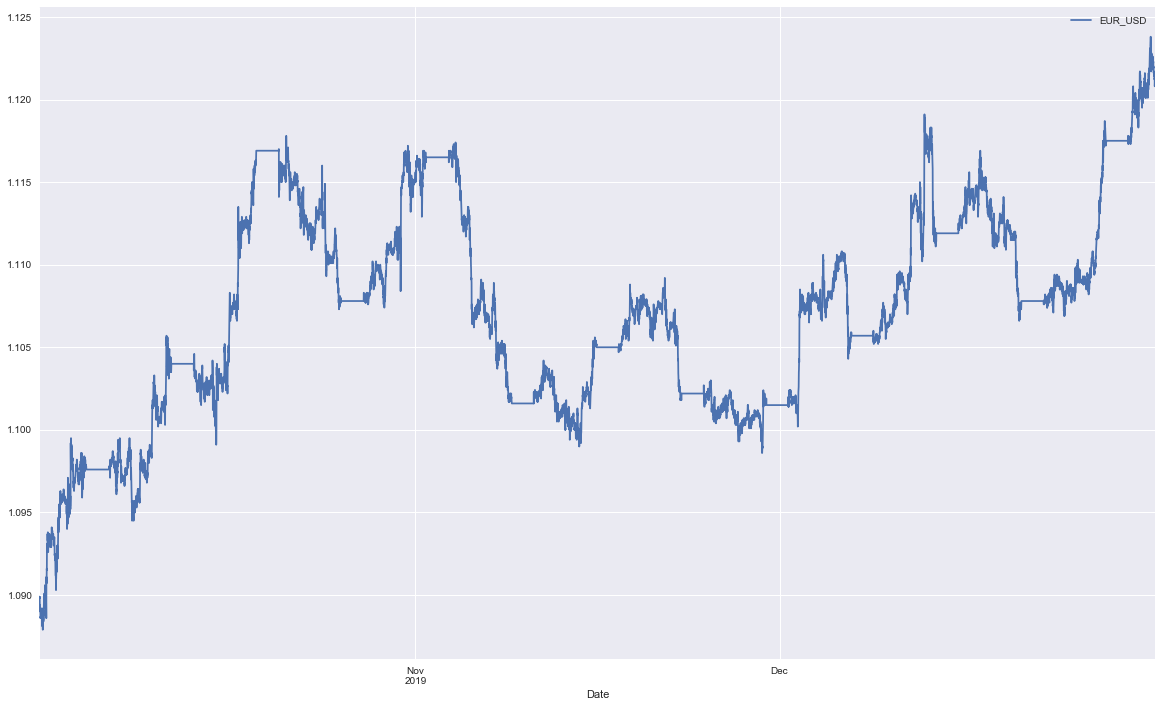

In [9]:
data.plot(figsize=(20,12))

In [10]:
# Now for the usual lags approach!
def add_lags(data, symbol, lags, window=50):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags+1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [11]:
data, cols = add_lags(data, symbol, 5)

In [12]:
def set_seeds():
    random.seed(100)
    np.random.seed(100)
    tf.compat.v1.random.set_random_seed(100)

In [13]:
set_seeds()

In [14]:
optimizer = 'adam' # Default Keras optimizer

In [15]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, # Input layer
                    input_dim=len(cols),
                   activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu')) # Hidden layers
    model.add(Dense(1, activation='sigmoid')) # Output Layer
    model.compile(loss='binary_crossentropy', # Loss function
                 optimizer=optimizer, # Optimizer Function
                 metrics=['accuracy']) # Other metrics to collect
    return model

In [16]:
set_seeds()
model = create_model(hl=1, hu=128)

In [17]:
%time model.fit(data[cols], data['d'], epochs=50, verbose=False, validation_data=(data[cols], data['d'])) 

CPU times: user 46.1 s, sys: 6.15 s, total: 52.3 s
Wall time: 34.2 s


In [18]:
model.evaluate(data[cols], data['d']) # Performance in sample - 70% accuracy!

413/413 [==============================] - 1s 1ms/step - loss: 0.5408 - accuracy: 0.7037


[0.5407745242118835, 0.7037458419799805]

In [19]:
split = int(len(data) * 0.8)
train = data.iloc[:split]
test = data.iloc[split:]
set_seeds()

In [20]:
model = create_model(hl=2, hu=128) # Why did this go to input layer of 2?

In [21]:
%%time
model.fit(train[cols], train['d'], epochs=50, verbose=False, validation_data=(data[cols], data['d']))

CPU times: user 48.7 s, sys: 6.05 s, total: 54.7 s
Wall time: 38.5 s


In [22]:
model.evaluate(train[cols], train['d'])

330/330 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7018


[0.5458658337593079, 0.7018009424209595]

In [23]:
model.evaluate(test[cols], test['d']) # out of sample actually better! A well trained model!

83/83 [==============================] - 0s 2ms/step - loss: 0.5141 - accuracy: 0.7115


[0.5140835046768188, 0.7115238904953003]

# Boosting Out-of-Sample Accuracy
* From here, we shift focus to improving the accuracy of out-of-sample performance
* Three candidates that improve out-of-sample accuracy are **Dropouts, Regularization, and Bagging**

In [24]:
mu, std = train.mean(), train.std()

In [25]:
train_ = (train - mu)/std # Gaussian Normalization

In [26]:
set_seeds()
model = create_model(hl=2, hu=128)

In [27]:
%%time
model.fit(train_[cols], train['d'], epochs=25, verbose=False, validation_split=0.2, shuffle=False )

CPU times: user 14.1 s, sys: 1.71 s, total: 15.8 s
Wall time: 10.7 s


In [28]:
model.evaluate(train_[cols], train['d']) # 76.6% in sample

330/330 [==============================] - 0s 824us/step - loss: 0.4826 - accuracy: 0.7662


[0.4825561046600342, 0.7661611437797546]

In [29]:
test_ = (test - mu)/std # 69.9% out of sample

In [30]:
model.evaluate(test_[cols], test['d'])

83/83 [==============================] - 0s 833us/step - loss: 0.6667 - accuracy: 0.6941


[0.6667026877403259, 0.6940864324569702]

# Dropouts
* The idea of dropouts is to **not use all units in a hidden layers during training**
* The result of this is the in-sample and out-sample performance both decreasing slightly, but the difference between in- and out- of sample shrinking

In [31]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu,
                  input_dim=len(cols),
                  activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl): # hl layers hu shaped
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # output
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [32]:
set_seeds()
model = create_model(hl=2, hu=128, rate=0.3)

In [33]:
%%time
model.fit(train_[cols], train['d'],
         epochs=25, verbose=False,
         validation_split=0.15, shuffle=False)

CPU times: user 13.5 s, sys: 1.78 s, total: 15.3 s
Wall time: 8.31 s


In [34]:
model.evaluate(train_[cols], train['d'])

330/330 [==============================] - 0s 785us/step - loss: 0.4809 - accuracy: 0.7272


[0.4808615446090698, 0.7272037863731384]

In [35]:
model.evaluate(test_[cols], test['d'])

83/83 [==============================] - 0s 789us/step - loss: 0.4946 - accuracy: 0.7123


[0.49461978673934937, 0.7122820615768433]

In [36]:
res = pd.DataFrame(model.history.history)

# Regularization
* Penalize large weights in the calculation of the loss function - this prevents any unit's weight from becoming dominant
* Two regularizers can be used - the L1 norm and the L2 norm.

In [41]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, regularize=False, reg=l1(0.0005),
                optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                   activity_regularizer=reg,
                   activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                       activity_regularizer=reg))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [42]:
set_seeds()
model = create_model(hl=2, hu=128, regularize=True)

In [48]:
%%time
model.fit(train_[cols], train['d'],
                 epochs=25, verbose=False,
                 validation_split=0.2, shuffle=False)

CPU times: user 12.6 s, sys: 1.64 s, total: 14.3 s
Wall time: 7.65 s


In [49]:
model.evaluate(train_[cols], train['d'])

330/330 [==============================] - 0s 969us/step - loss: 0.5109 - accuracy: 0.8587


[0.5109453201293945, 0.8586729764938354]

In [50]:
model.evaluate(test_[cols], test['d'])

83/83 [==============================] - 0s 1ms/step - loss: 1.2237 - accuracy: 0.6793


[1.2236555814743042, 0.6793025135993958]

In [51]:
# Use dropouts and regularization together!
set_seeds()
model = create_model(hl=2, hu=128,
                    dropout=True, rate=0.3,
                    regularize=True, reg=l2(0.001))


In [52]:
%%time
model.fit(train_[cols], train['d'],
         epochs=25, verbose=False,
         validation_split=0.2, shuffle=False)

CPU times: user 14 s, sys: 1.92 s, total: 15.9 s
Wall time: 8.57 s


In [54]:
model.evaluate(train_[cols], train['d'])

330/330 [==============================] - 0s 993us/step - loss: 0.4995 - accuracy: 0.7217


[0.49947965145111084, 0.7217061519622803]

In [55]:
model.evaluate(test[cols], test['d'])

83/83 [==============================] - 0s 1ms/step - loss: 0.5950 - accuracy: 0.7115


[0.5949754118919373, 0.7115238904953003]

# Bagging
* Bagging reduces overfitting my exposing multipler identical neural nets to sub-portions of the feature set and training data, then combining the results

In [57]:
max_features = 0.75
set_seeds()
base_estimator = KerasClassifier(build_fn=create_model,
                                verbose=False, epochs=20, hl=1, hu=128,
                                dropout=False, regularize=True,
                                input_dim=int(len(cols) * max_features))

In [58]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                             n_estimators=15,
                             max_samples=0.75,
                             max_features=max_features,
                             bootstrap=True,
                             bootstrap_features=True,
                             n_jobs=1,
                             random_state=100)

In [59]:
%time model_bag.fit(train_[cols], train['d'])

CPU times: user 1min 47s, sys: 14.6 s, total: 2min 2s
Wall time: 1min 7s


BaggingClassifier(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x14268bef0>,
                  bootstrap=True, bootstrap_features=True, max_features=0.75,
                  max_samples=0.75, n_estimators=15, n_jobs=1, oob_score=False,
                  random_state=100, verbose=0, warm_start=False)